In [2]:
import pandas as pd
import seaborn as sns

# Performance comparison

## Sklearn datasets make_blobs

<Axes: xlabel='x', ylabel='y'>

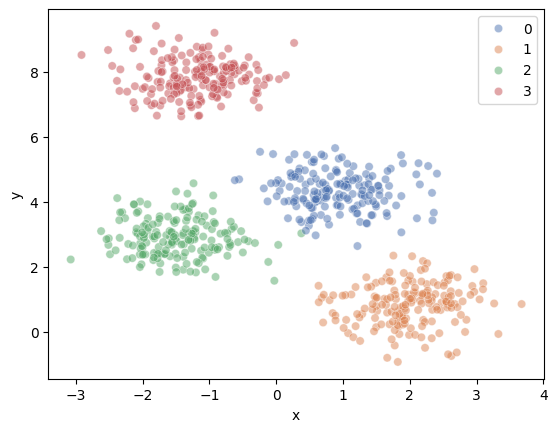

In [3]:
from sklearn.datasets import make_blobs
X, cluster_assignments = make_blobs(n_samples=700, centers=4, cluster_std=0.60, random_state=0)
df = pd.DataFrame(X, columns = ["x", "y"])
sns.scatterplot(data=df, x=df.x, y=df.y, hue=cluster_assignments, palette="deep", alpha=0.5)

## My own implementation of KMeans

<Axes: xlabel='x', ylabel='y'>

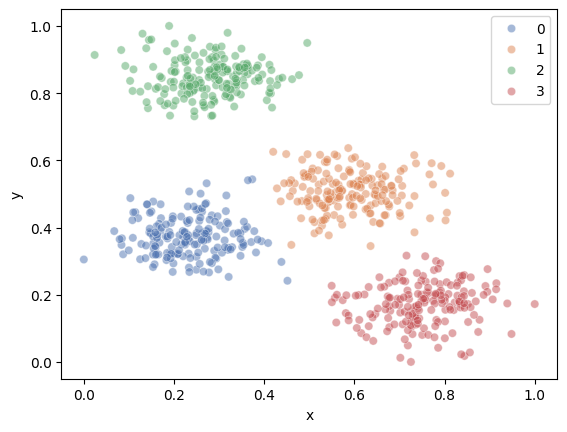

In [4]:
from KMeans import KMeans
kmeans = KMeans(k=4)
clusters, centroids = kmeans.fit(X)
sns.scatterplot(data=df, x=df.x, y=df.y, hue=clusters, palette="deep", alpha=0.5)

### V-measure score

In [5]:
from sklearn.metrics.cluster import v_measure_score

label_mapping = {0 : 2, 1 : 3, 2 : 0, 3 : 1} # my own verion to correct one
for i in range(len(clusters)):
    clusters[i] = label_mapping[clusters[i]]
v_measure_score_my_version = v_measure_score(cluster_assignments, clusters)
print(v_measure_score_my_version)

0.9774696268721368


## KMeans from sklearn

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

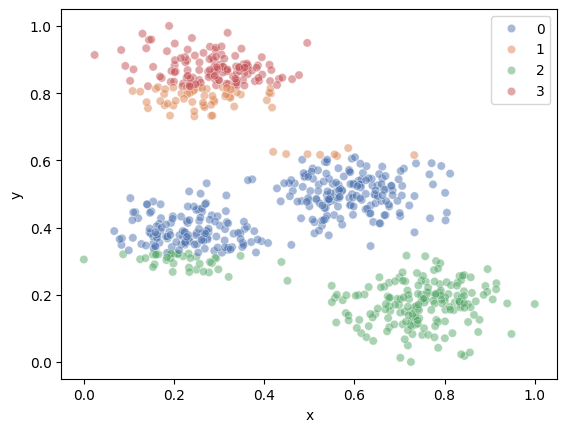

In [6]:
from sklearn.cluster import KMeans

kmeans_sklearn = KMeans(n_clusters=4, n_init='auto')
kmeans_sklearn.fit(df.iloc[:,1:])
sns.scatterplot(data=df, x=df.x, y=df.y, hue=kmeans_sklearn.labels_, palette="deep", alpha=0.5)

In [7]:
label_mapping_sklearn = {0 : 3, 1 : 2, 2 : 1, 3 : 0} # sklearn version to the correct one
for i in range(len(kmeans_sklearn.labels_)):
    kmeans_sklearn.labels_[i] = label_mapping[kmeans_sklearn.labels_[i]]
v_measure_score_sklearn_version = v_measure_score(cluster_assignments, kmeans_sklearn.labels_)
print(v_measure_score_sklearn_version)

0.6917232306711397


## Performance comparison
For consistency, I will use the naming according to the graph from make_blobs (the first graph) where red group refers to the top one, green group refers to the middle left one, blue group refers to the middle right one, and orange group refers to the buttom one.
All the three graphs have similar group red and group orange while the one of my own implementation has the middle two groups more similar to the one from make_blobs with slightly different on the boundaries
Also, my implementation has a  higher v-measure score of 0.9774696268721368 v-measure score than the one of sklearn that has only 0.6917232306711397

# Choose and run clustering algorithms

## Chicago taxi

### EDA

In [8]:
df_taxi = pd.read_csv('Taxi_Trips__2013-2023_.csv')

In [9]:
df_taxi.describe()

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,101763.000000,101788.000000,3.517900e+04,3.505400e+04,95650.000000,92192.000000,101681.000000,101681.000000,101681.000000,101681.000000,101681.000000,95657.000000,95657.000000,92489.000000,92489.000000
mean,1102.644891,6.021135,1.703149e+10,1.703140e+10,33.230946,25.300764,20.466054,2.452347,0.014503,1.679117,24.739358,41.898703,-87.689956,41.892116,-87.657546
std,1831.031101,7.572349,3.696445e+05,3.377955e+05,25.309183,20.270499,18.103452,3.918353,0.602782,5.208910,22.641634,0.064621,0.104274,0.059306,0.063430
min,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.913625,41.660136,-87.913625
25%,420.000000,0.870000,1.703108e+10,1.703108e+10,8.000000,8.000000,7.750000,0.000000,0.000000,0.000000,9.500000,41.878866,-87.695013,41.878866,-87.663518
50%,836.000000,2.600000,1.703132e+10,1.703132e+10,32.000000,28.000000,13.500000,0.000000,0.000000,0.000000,16.000000,41.895033,-87.642649,41.892508,-87.633308
75%,1516.000000,10.800000,1.703184e+10,1.703184e+10,50.000000,32.000000,31.000000,3.000000,0.000000,1.000000,33.900000,41.949829,-87.626211,41.922686,-87.625192
max,86003.000000,814.300000,1.703198e+10,1.703198e+10,77.000000,77.000000,999.000000,250.000000,78.000000,182.000000,999.000000,42.015934,-87.534903,42.021224,-87.534903


In [10]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101788 entries, 0 to 101787
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Trip ID                     101788 non-null  object 
 1   Taxi ID                     101779 non-null  object 
 2   Trip Start Timestamp        101788 non-null  object 
 3   Trip End Timestamp          101788 non-null  object 
 4   Trip Seconds                101763 non-null  float64
 5   Trip Miles                  101788 non-null  float64
 6   Pickup Census Tract         35179 non-null   float64
 7   Dropoff Census Tract        35054 non-null   float64
 8   Pickup Community Area       95650 non-null   float64
 9   Dropoff Community Area      92192 non-null   float64
 10  Fare                        101681 non-null  float64
 11  Tips                        101681 non-null  float64
 12  Tolls                       101681 non-null  float64
 13  Extras        

### Data pre-processing

#### Data cleaning

In [11]:
df_taxi = df_taxi.iloc[:,17:19]
df_taxi

,Pickup Centroid Latitude,Pickup Centroid Longitude
0,41.980264,-87.913625
1,41.878866,-87.625192
2,41.899602,-87.633308
3,41.979071,-87.903040
4,41.980264,-87.913625
...,...,...
101783,41.885281,-87.657233
101784,41.899602,-87.633308
101785,41.899602,-87.633308
101786,41.980264,-87.913625


In [12]:
df_taxi = df_taxi.dropna()
df_taxi

,Pickup Centroid Latitude,Pickup Centroid Longitude
0,41.980264,-87.913625
1,41.878866,-87.625192
2,41.899602,-87.633308
3,41.979071,-87.903040
4,41.980264,-87.913625
...,...,...
101782,41.878866,-87.625192
101783,41.885281,-87.657233
101784,41.899602,-87.633308
101785,41.899602,-87.633308


In [13]:
df_taxi.reset_index(inplace=True, drop=True)
df_taxi

,Pickup Centroid Latitude,Pickup Centroid Longitude
0,41.980264,-87.913625
1,41.878866,-87.625192
2,41.899602,-87.633308
3,41.979071,-87.903040
4,41.980264,-87.913625
...,...,...
95652,41.878866,-87.625192
95653,41.885281,-87.657233
95654,41.899602,-87.633308
95655,41.899602,-87.633308


<Axes: xlabel='Pickup Centroid Latitude', ylabel='Pickup Centroid Longitude'>

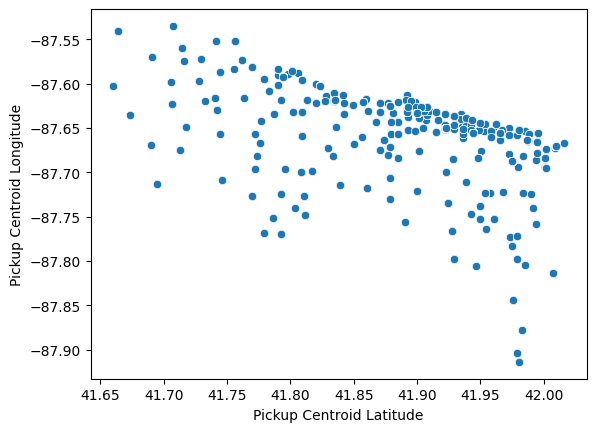

In [14]:
sns.scatterplot(data=df_taxi, x=df_taxi['Pickup Centroid Latitude'], y=df_taxi['Pickup Centroid Longitude'])

#### Data normalizing

In [15]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(df_taxi.iloc[:,:])
df_taxi_normalized = ss.transform(df_taxi.iloc[:,:])
df_taxi_normalized

array([[ 1.26216408, -2.14503019],
       [-0.30698521,  0.62109854],
       [ 0.01391335,  0.54326538],
       ...,
       [ 0.01391335,  0.54326538],
       [ 0.01391335,  0.54326538],
       [ 1.26216408, -2.14503019]])

### Determining the best value for k for KMeans

<Axes: >

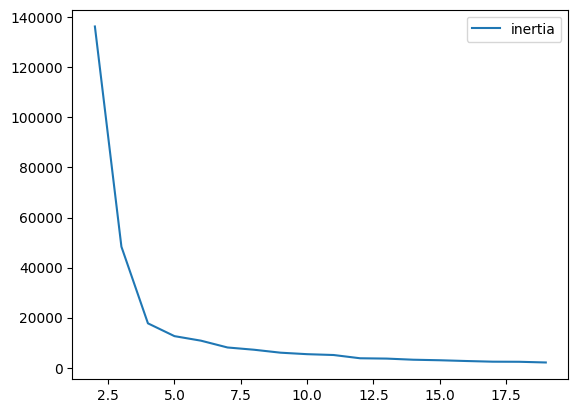

In [36]:
df_taxi_normalized = pd.DataFrame(df_taxi_normalized, columns=['Pickup latitude', 'Pickup longitude'])
inertias = pd.DataFrame(data=[], index=range(2, 20), columns=['inertia'])

for k in range(2, 20):
    taxi_kmeans = KMeans(n_clusters=k, n_init='auto')
    taxi_kmeans.fit(df_taxi_normalized)
    inertias.loc[k] = taxi_kmeans.inertia_
inertias.plot()

### Implementing KMeans

<Axes: xlabel='Pickup latitude', ylabel='Pickup longitude'>

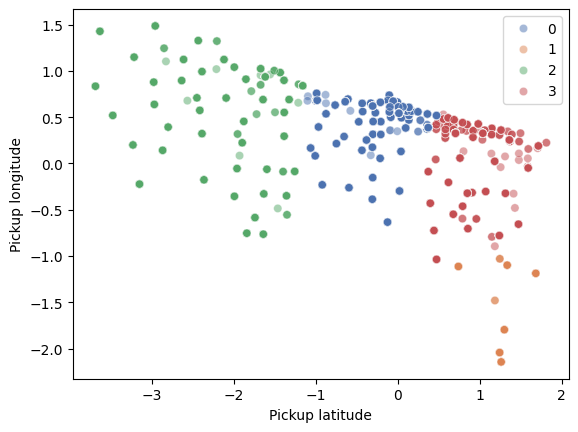

In [38]:
k = 4 # According to the figure, I choose 4 for the k
taxi_kmeans = KMeans(n_clusters=k, n_init='auto')
taxi_kmeans.fit(df_taxi_normalized)
sns.scatterplot(data=df_taxi_normalized, x=df_taxi_normalized['Pickup latitude'], y=df_taxi_normalized['Pickup longitude'], hue=taxi_kmeans.labels_, palette="deep", alpha=0.5)

### Performance evaluation

In [40]:
from sklearn.metrics import silhouette_score

silhouette_score_taxi = silhouette_score(df_taxi_normalized, taxi_kmeans.labels_, metric = 'euclidean')
silhouette_score_taxi

0.7031324453085858

## Questions
1. The reason why you chose the clustering algorithm(s)
2. Any pre-processing of the data or any hyperparameter settings
3. Output from the algorithm(s) -- show what clusters were generated
4. The metrics you used to evaluate the output. What kind of performance did you get from that algorithm? Is that what you expected?

## Answers to the questions
1. In the case of taxi picking up customers, I used KMeans to find several (4 in this case) clusters where taxi drivers pick up customers so that we can know maybe where to locate the taxi centers (where taxi companies can send out taxis to pick up customers) to shorten the distance between taxi centers and the customers and to maintain the least number of centers for cost saving.
2. I cleaned (drop) the data that has null value of pickup centroid latitude and pickup centroid longitude, normalizing the data before I apply KMeans to it. I employed elbow method for cluster number from 2 to 19, and I find the elbow where the cluster number is 4.
3. The output is shown as above. There are four clusters.
4. I used Silhouette score which is range from -1 to 1 to measure the performance, and I got 0.7031324453085858 for it, which is quite high where the higher value indicates that the points are placed in the correct clusters. The score is quite high as I expected that finding a decent value for the cluster number would result in a good score for the clustering.

## Mopsi data

### EDA

In [41]:
df_mopsi = pd.read_csv('MopsiLocationsUntil2012-Finland.txt', sep='\t', header=None)
df_mopsi.columns = ['x', 'y'] # Since it is a dataset of location, I label the feature as x and y coordinate
df_mopsi

,x,y
0,625983,297439
1,626146,297440
2,626144,297456
3,626004,297394
4,626018,297437
...,...,...
13462,626042,297444
13463,625977,297443
13464,626050,297404
13465,625995,297426


In [42]:
df_mopsi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13467 entries, 0 to 13466
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       13467 non-null  int64
 1   y       13467 non-null  int64
dtypes: int64(2)
memory usage: 210.5 KB


In [43]:
df_mopsi.describe()

,x,y
count,13467.000000,13467.000000
mean,625094.775897,289004.669043
std,7844.331518,20399.428325
min,599247.000000,212016.000000
25%,625930.000000,296164.000000
50%,626018.000000,297448.000000
75%,626192.000000,297796.500000
max,697835.000000,314328.000000


<Axes: xlabel='x', ylabel='y'>

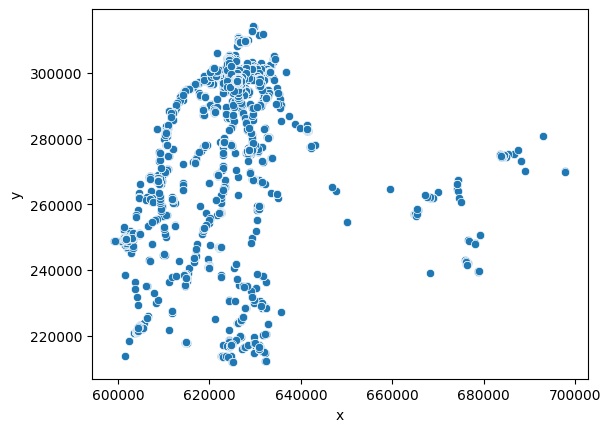

In [45]:
sns.scatterplot(data=df_mopsi, x=df_mopsi.x, y=df_mopsi.y)

Since there is no null value in the data and no obvious outlier, there is no need to clean the data

### Data normalizing

In [46]:
ss_mopsi = StandardScaler()
ss_mopsi.fit(df_mopsi.iloc[:,:])
df_mopsi_normalized = ss_mopsi.transform(df_mopsi.iloc[:,:])
df_mopsi_normalized

array([[0.11323554, 0.41347453],
       [0.13401564, 0.41352356],
       [0.13376067, 0.41430792],
       ...,
       [0.12177705, 0.41175874],
       [0.11476536, 0.41283724],
       [0.11310805, 0.41308235]])

### Determine the best value for epsilon
Using the approach from https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan

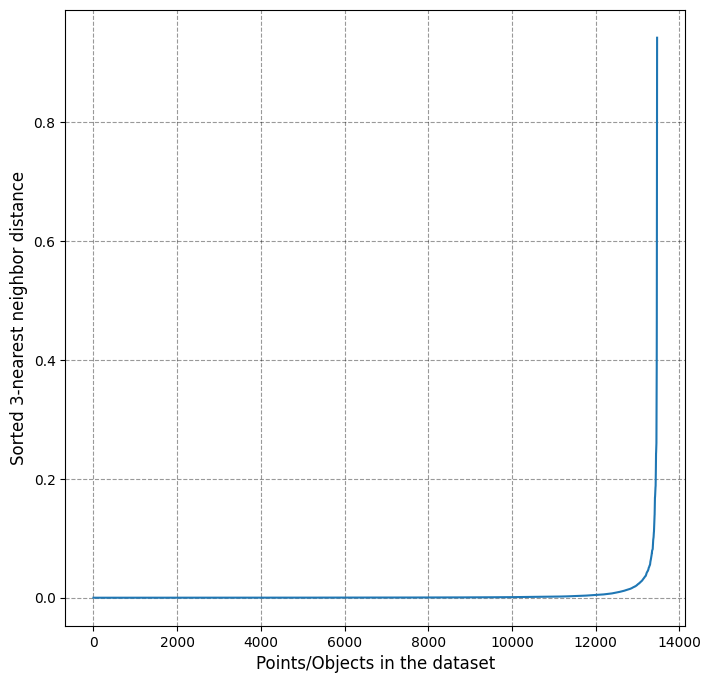

In [47]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

n = 2 # the dimension of the dataset
k = 2 * n - 1 # 2 * n - 1

nbrs = NearestNeighbors(n_neighbors=k).fit(df_mopsi_normalized)

distances, indices = nbrs.kneighbors(df_mopsi_normalized)
                                   
distances = np.sort(distances, axis=0)
distances = distances[:, k-1]

plt.figure(figsize=(8,8))
plt.plot(distances)
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

### Implement DBSCAN

<Axes: xlabel='x', ylabel='y'>

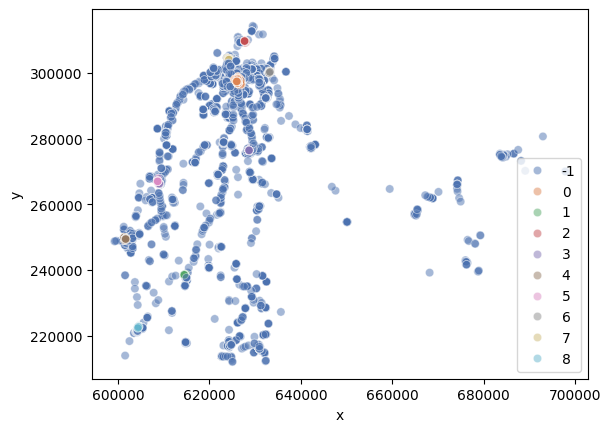

In [65]:
from sklearn.cluster import DBSCAN

min_samples = 100 # experimental result. Using 100 so that there won't be too many clusters
eps = 0.03 # According to the figure, the elbow is approximately at eps = 0.05
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df_mopsi_normalized)
sns.scatterplot(data=df_mopsi, x=df_mopsi.x, y=df_mopsi.y, hue=dbscan.labels_, palette='deep', alpha=0.5)

### Performance evaluation

In [67]:
silhouette_score_mopsi = silhouette_score(df_mopsi_normalized, dbscan.labels_, metric = 'euclidean')
silhouette_score_mopsi

0.503181194868041

## Questions
1. The reason why you chose the clustering algorithm(s)
2. Any pre-processing of the data or any hyperparameter settings
3. Output from the algorithm(s) -- show what clusters were generated
4. The metrics you used to evaluate the output. What kind of performance did you get from that algorithm? Is that what you expected?

## Answer to the question
1. I used DBSCAN as a density-based clustering algorithm so that I know where is the most popular place to go in Finland, such as attraction, heritage, or just Costco where there are usually many people. The result can be used to find the places where disease is easily to spread out due to the high density of population and so on.
2. Since there is no null value in the dataset, I don't have to clean the data. I normalized the data so that we can cluster properly. I used the nearestneighbor from sklearn.neighbors to plot the figure to find the elbow for epsilon, and I tried several values for min_samples to find a better value in this case where 100 gave us 8 clusters while 10 gave us more than 100 clusters.
3. The output from the algorithm is shown above. There are 8 very dense clusters which are very popular.
4. I used Silhouette score for performance evaluation. It's pretty high, which means most points are in the correct clusters. I thought it would be a little bit lower since there are so many outliers indicated by -1 on the figure